# 4. Modeling

## 4.1 Introduction

With each antibiotic data split into two train/test splits of 80/20 and 70/30, it's time to model. I will be using random forest and Xgboosting models, which are suitable for this entirely binary dataset. The main metric I am optimizing for is recall, as false negatives would indicate that a strain is sensitive to an antibiotic when it is reality is resistant. This is the worst case scenario as it would recommend a patient take an ineffective antibiotic.

## 4.2 Importing Packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

## 4.3 Loading Data

In [2]:
azm_X_train80 = pd.read_csv('../data/processed/azm_X_train80.csv')
azm_X_test80 = pd.read_csv('../data/processed/azm_X_test80.csv')
azm_y_train80 = pd.read_csv('../data/processed/azm_y_train80.csv')
azm_y_test80 = pd.read_csv('../data/processed/azm_y_test80.csv')

azm_X_train70 = pd.read_csv('../data/processed/azm_X_train70.csv')
azm_X_test70 = pd.read_csv('../data/processed/azm_X_test70.csv')
azm_y_train70 = pd.read_csv('../data/processed/azm_y_train70.csv')
azm_y_test70 = pd.read_csv('../data/processed/azm_y_test70.csv')

In [3]:
cip_X_train80 = pd.read_csv('../data/processed/cip_X_train80.csv')
cip_X_test80 = pd.read_csv('../data/processed/cip_X_test80.csv')
cip_y_train80 = pd.read_csv('../data/processed/cip_y_train80.csv')
cip_y_test80 = pd.read_csv('../data/processed/cip_y_test80.csv')

cip_X_train70 = pd.read_csv('../data/processed/cip_X_train70.csv')
cip_X_test70 = pd.read_csv('../data/processed/cip_X_test70.csv')
cip_y_train70 = pd.read_csv('../data/processed/cip_y_train70.csv')
cip_y_test70 = pd.read_csv('../data/processed/cip_y_test70.csv')

In [4]:
cfx_X_train80 = pd.read_csv('../data/processed/cfx_X_train80.csv')
cfx_X_test80 = pd.read_csv('../data/processed/cfx_X_test80.csv')
cfx_y_train80 = pd.read_csv('../data/processed/cfx_y_train80.csv')
cfx_y_test80 = pd.read_csv('../data/processed/cfx_y_test80.csv')

cfx_X_train70 = pd.read_csv('../data/processed/cfx_X_train70.csv')
cfx_X_test70 = pd.read_csv('../data/processed/cfx_X_test70.csv')
cfx_y_train70 = pd.read_csv('../data/processed/cfx_y_train70.csv')
cfx_y_test70 = pd.read_csv('../data/processed/cfx_y_test70.csv')

In [5]:
# Convert y to 1D arrays
azm_y_train80 = azm_y_train80['resistant']
azm_y_test80 = azm_y_test80['resistant']
azm_y_train70 = azm_y_train70['resistant']
azm_y_test70 = azm_y_test70['resistant']
cip_y_train80 = cip_y_train80['resistant']
cip_y_test80 = cip_y_test80['resistant']
cip_y_train70 = cip_y_train70['resistant']
cip_y_test70 = cip_y_test70['resistant']
cfx_y_train80 = cfx_y_train80['resistant']
cfx_y_test80 = cfx_y_test80['resistant']
cfx_y_train70 = cfx_y_train70['resistant']
cfx_y_test70 = cfx_y_test70['resistant']

## 4.4 Initial Modeling
First I attempted initial models of each antibiotic to confirm that Random Forest and Gradient Boosting are promising.

In [6]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

I created dictionaries containing the various training and test splits to make them more accessible in this exploration.

In [7]:
azm_splits = {'80/20': (azm_X_train80, azm_X_test80, azm_y_train80, azm_y_test80),
             '70/30': (azm_X_train70, azm_X_test70, azm_y_train70, azm_y_test70)}
cip_splits = {'80/20': (cip_X_train80, cip_X_test80, cip_y_train80, cip_y_test80),
             '70/30': (cip_X_train70, cip_X_test70, cip_y_train70, cip_y_test70)}
cfx_splits = {'80/20': (cfx_X_train80, cfx_X_test80, cfx_y_train80, cfx_y_test80),
             '70/30': (cfx_X_train70, cfx_X_test70, cfx_y_train70, cfx_y_test70)}

In order to compare the recall and ROC AUC scores, I created a function that creates a plot of these scores for each split for both random forest and Xgboost models.

In [8]:
def initial_model_exploration(antibiotic, train_test_splits):
    """This function takes the dictionary with train test splits and for each split ratio, trains
    a random forest and Xgboost model, records train and test recall and ROC AUC scores, and plots
    the results using the antibiotic name."""
    
    model_names = []
    splits = []
    recall_scores = []
    roc_auc_scores = []

    rf_initial = RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=True, random_state=12)
    xgbc_initial = xgb.XGBClassifier(random_state=13)
    cv_initial = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=22)
    models = {'Random forest': rf_initial,
             'Xgboost': xgbc_initial}
    
    for model_name, model in models.items():
        for ratio, split in train_test_splits.items():
            X_train, X_test, y_train, y_test = split

            model_names.append(model_name)
            splits.append(f'{ratio} train')
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            train_recall = recall_score(y_train, y_train_pred)
            recall_scores.append(train_recall)
            train_roc_auc = cross_val_score(model, X_train, y_train, cv=cv_initial, scoring='roc_auc', n_jobs=-1)
            roc_auc_scores.append(train_roc_auc.mean())

            model_names.append(model_name)
            splits.append(f'{ratio} test')
            y_test_pred = model.predict(X_test)
            test_recall = recall_score(y_test, y_test_pred)
            recall_scores.append(test_recall)
            test_roc_auc = cross_val_score(model, X_test, y_test, cv=cv_initial, scoring='roc_auc', n_jobs=-1)
            roc_auc_scores.append(test_roc_auc.mean())
        
    df = pd.DataFrame({'model': model_names,
                  'split': splits,
                  'recall_score': recall_scores,
                  'roc_auc_score': roc_auc_scores})
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
    g = sns.barplot(ax=ax1, data=df, x='model', y='recall_score', hue='split')
    g.set_title(f"Recall scores")
    g.set_xlabel("Model")
    g.set_ylabel("Recall score")
    ax1.set_ylim(0,1)
    ax1.get_legend().remove()
    h = sns.barplot(ax=ax2, data=df, x='model', y='roc_auc_score', hue='split')
    h.set_title(f"ROC AUC scores")
    h.set_xlabel("Model")
    h.set_ylabel("ROC AUC score")
    ax2.set_ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle(f'Initial models for {antibiotic}', fontsize=16)
    plt.show()

### 4.4.1 azm Model Exploration

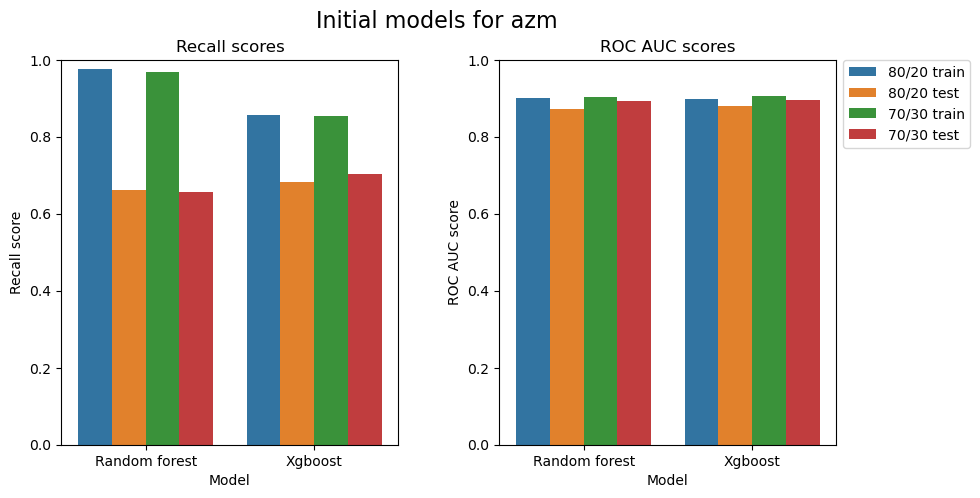

In [9]:
initial_model_exploration('azm', azm_splits)

For azm, there is a drastic difference between training and test recall scores, particularly among the random forest models. Xgboost appears to perform better, with the 70/30 split having slightly higher scores than the 80/20 split.

### 4.4.2 cip Model Exploration

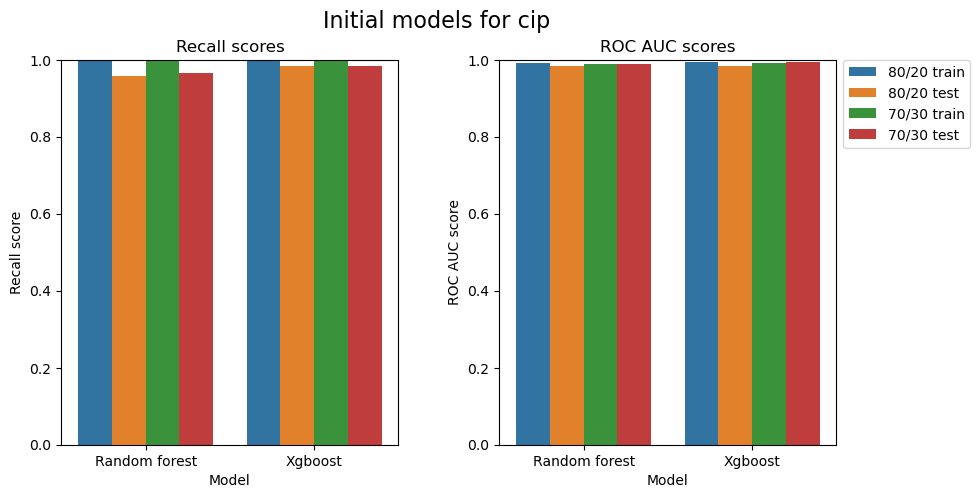

In [10]:
initial_model_exploration('cip', cip_splits)

For cip, all models are performing better than the azm models across the board, with training recall as well as all ROC AUC scores close to 1. Xgboost's test recall is slightly higher than the random forest models.

### 4.4.3 cfx Model Exploration

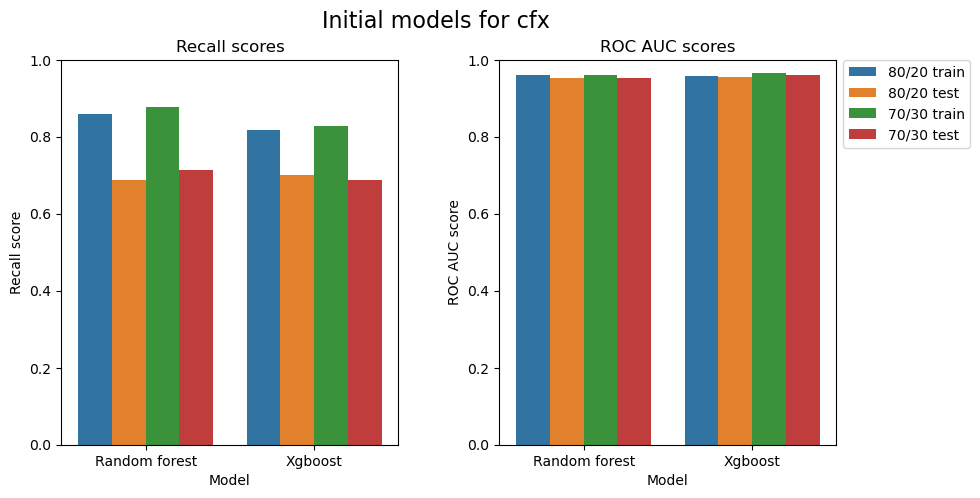

In [11]:
initial_model_exploration('cfx', cfx_splits)

For the cfx models, the recall scores were lower, similar to azm, with test recall approximately 0.7 and the best recall coming from the random forest model for the 70/30 split. Random forest appears to outpeform the Xgboost on recall, but ROC AUC scores show very little variation.

## 4.5 Random Forest Hyperparameter Tuning

In order to tune the random forest models, I performed a random grid search of the following hyperparameters:
<ul>
    <li>n_estimators</li>
    <li>criterion</li>
    <li>max_features</li>
    <li>max_depth</li>
    <li>min_samples_split</li>
    <li>min_samples_leaf</li>
</ul>

In [12]:
from sklearn.metrics import precision_score
from sklearn.model_selection import RandomizedSearchCV

random_grid_rf = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
             'criterion': ['gini', 'entropy'],
             'max_features': ['sqrt', 'log2'],
             'max_depth': [int(x) for x in np.linspace(10, 100, num = 10)],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=31)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid_rf,
                              n_iter=60, scoring='recall', n_jobs=-1, cv=cv, random_state=50)

I made a function to plot the mean test scores and the mean fit times to determine which models to fine tune.

In [13]:
def plot_search_results(data, model_name, antibiotic_name, split):
    """This function takes a dataframe 'data' generated by a model's cross validation results
    and the labels of the model's name, the antibiotic used for the data, and the split ratio,
    and the function plots the test scores and fit times and correctly labels the plots."""
    df = data.head(10)
    x = list(range(1,11))
    fig, (ax1,ax2) = plt.subplots(1,2)
    g = sns.barplot(ax=ax1, data=df, x=x, y='mean_test_score', yerr=df['std_test_score'])
    ax1.set_xticklabels(df['rank_test_score'])
    g.set_title(f"Test scores for {model_name}\nmodel of {antibiotic_name} {split} split")
    g.set_xlabel("Test score rank")
    g.set_ylabel("Mean test score")
    h = sns.barplot(ax=ax2, data=df, x=x, y='mean_fit_time', yerr=df['std_fit_time'])
    h.set_xticklabels(df['rank_test_score'])
    h.set_title(f"Fit times for {model_name}\nmodel of {antibiotic_name} {split} split")
    h.set_xlabel("Test score rank")
    h.set_ylabel("Mean fit time")
    plt.subplots_adjust(wspace=0.5)
    plt.show()

### 4.5.1 azm Random Forest

Best score: 0.6581033262561925
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'entropy'}


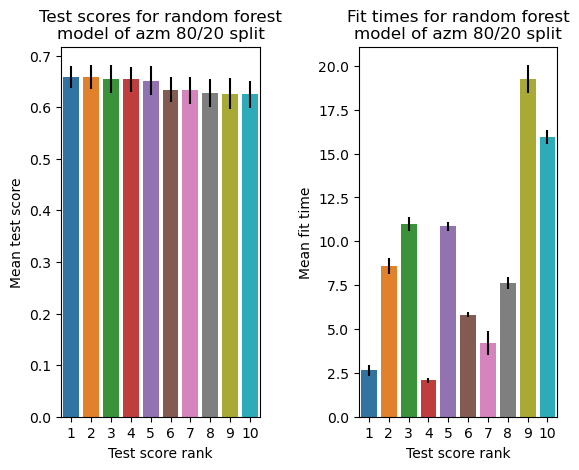

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
33,2.639564,0.334231,0.094039,0.014754,200,2,1,sqrt,80,entropy,...,0.660256,0.647436,0.653846,0.656051,0.666667,0.673077,0.666667,0.658103,0.021781,1
6,8.598646,0.444711,0.354899,0.048477,800,2,1,sqrt,80,entropy,...,0.641026,0.653846,0.660256,0.662420,0.666667,0.666667,0.653846,0.657676,0.023258,2
51,11.000079,0.404083,0.443449,0.022609,1000,2,1,sqrt,80,entropy,...,0.647436,0.647436,0.660256,0.668790,0.673077,0.666667,0.647436,0.654685,0.027474,3
50,2.076065,0.139058,0.089847,0.008243,200,2,1,sqrt,40,gini,...,0.647436,0.641026,0.660256,0.649682,0.660256,0.673077,0.628205,0.653835,0.023883,4
2,10.844314,0.273680,0.450719,0.031305,1000,2,1,sqrt,40,entropy,...,0.634615,0.641026,0.660256,0.662420,0.666667,0.666667,0.647436,0.651268,0.027632,5
57,5.819035,0.132834,0.258694,0.015659,600,5,1,sqrt,40,entropy,...,0.621795,0.615385,0.634615,0.630573,0.653846,0.647436,0.621795,0.633780,0.023949,6
15,4.189011,0.677799,0.174583,0.016875,400,5,1,sqrt,40,gini,...,0.608974,0.615385,0.641026,0.630573,0.653846,0.660256,0.608974,0.632925,0.026314,7
56,7.614638,0.333137,0.396786,0.114806,800,2,1,log2,100,gini,...,0.596154,0.621795,0.634615,0.630573,0.641026,0.634615,0.628205,0.627372,0.026299,8
9,19.244240,0.819116,1.010589,0.204094,2000,2,1,log2,70,entropy,...,0.583333,0.621795,0.634615,0.643312,0.634615,0.628205,0.621795,0.626079,0.030008,9
27,15.933276,0.398795,0.864328,0.073248,1800,10,1,sqrt,100,entropy,...,0.608974,0.602564,0.621795,0.617834,0.653846,0.634615,0.608974,0.624822,0.025708,10


In [14]:
rf_result_azm80 = rf_random.fit(azm_X_train80, azm_y_train80)
df_rf_result_azm80 = pd.DataFrame(rf_result_azm80.cv_results_).sort_values('rank_test_score')
print(f'Best score: {rf_result_azm80.best_score_}')
print(f'Best parameters: {rf_result_azm80.best_params_}')
plot_search_results(df_rf_result_azm80, "random forest", "azm", "80/20")
df_rf_result_azm80.head(10)

The best mean test recall was 0.652129 and its mean fit time was 9.672399 seconds, which was the shortest fit time of the top 7 ranking models. Its hyperparameters are as follows:

In [15]:
rf_azm80_best_params = df_rf_result_azm80['params'].iloc[0]
rf_azm80_best_params

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'criterion': 'entropy'}

Best score: 0.6398561614426792
Best parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'entropy'}


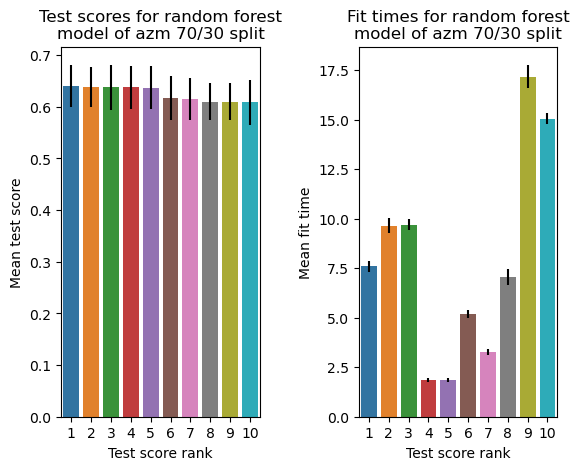

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
6,7.589188,0.271183,0.318575,0.025488,800,2,1,sqrt,80,entropy,...,0.617647,0.720588,0.671533,0.620438,0.620438,0.676471,0.654412,0.639856,0.040252,1
51,9.641764,0.371291,0.404021,0.023540,1000,2,1,sqrt,80,entropy,...,0.617647,0.720588,0.671533,0.620438,0.620438,0.676471,0.654412,0.638393,0.039502,2
2,9.709111,0.258108,0.410006,0.028977,1000,2,1,sqrt,40,entropy,...,0.617647,0.742647,0.671533,0.613139,0.620438,0.676471,0.639706,0.637910,0.043613,3
33,1.873831,0.101008,0.079645,0.004304,200,2,1,sqrt,80,entropy,...,0.617647,0.735294,0.671533,0.635036,0.620438,0.669118,0.625000,0.637899,0.041338,4
50,1.854538,0.120225,0.082602,0.005034,200,2,1,sqrt,40,gini,...,0.610294,0.735294,0.671533,0.620438,0.620438,0.661765,0.654412,0.636929,0.041538,5
57,5.186105,0.196352,0.243066,0.014551,600,5,1,sqrt,40,entropy,...,0.602941,0.713235,0.656934,0.591241,0.583942,0.669118,0.625000,0.616931,0.043094,6
15,3.270603,0.141301,0.153012,0.010812,400,5,1,sqrt,40,gini,...,0.602941,0.698529,0.642336,0.605839,0.583942,0.661765,0.625000,0.614978,0.041137,7
56,7.047325,0.408610,0.335534,0.017546,800,2,1,log2,100,gini,...,0.625000,0.683824,0.664234,0.591241,0.576642,0.617647,0.602941,0.610083,0.036139,8
9,17.183216,0.596291,0.879953,0.054081,2000,2,1,log2,70,entropy,...,0.602941,0.683824,0.664234,0.591241,0.591241,0.625000,0.602941,0.610079,0.035280,9
53,15.057647,0.267624,0.770557,0.056596,2000,2,2,sqrt,100,entropy,...,0.610294,0.683824,0.620438,0.583942,0.583942,0.625000,0.610294,0.608623,0.043616,10


In [16]:
rf_result_azm70 = rf_random.fit(azm_X_train70, azm_y_train70)
df_rf_result_azm70 = pd.DataFrame(rf_result_azm70.cv_results_).sort_values('rank_test_score')
print(f'Best score: {rf_result_azm80.best_score_}')
print(f'Best parameters: {rf_result_azm80.best_params_}')
plot_search_results(df_rf_result_azm70, "random forest", "azm", "70/30")
df_rf_result_azm70.head(10)

For the 70/30 split, the best recall was 0.634496 and its fit time was 7.612719 seconds. While this is faster than the 80/20 split, the recall is substantially lower, so the most promising model thus far is the 80/20 split with the parameters detailed above.

### 4.5.2 cip Random Forest

Reduce the values of n_estimators and max_depth to save computing time.

In [17]:
random_grid_rf_cip = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1400, num = 7)],
             'criterion': ['gini', 'entropy'],
             'max_features': ['sqrt', 'log2'],
             'max_depth': [int(x) for x in np.linspace(10, 50, num = 9)],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],}

rf_random_cip = RandomizedSearchCV(estimator=rf, param_distributions=random_grid_rf_cip,
                              n_iter=60, scoring='recall', n_jobs=-1, cv=cv, random_state=50)

Best score: 0.9623432671927272
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}


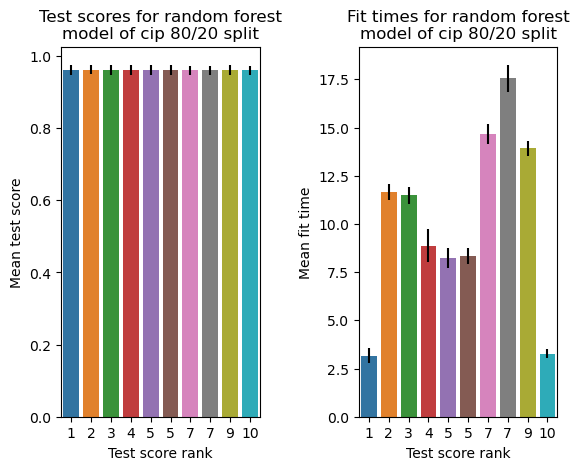

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
41,3.168573,0.401644,0.268193,0.051558,200,10,1,sqrt,10,entropy,...,0.978166,0.969432,0.960526,0.964912,0.978070,0.973799,0.930131,0.962343,0.013636,1
9,11.660781,0.396883,0.498250,0.062020,800,5,1,sqrt,10,gini,...,0.965066,0.965066,0.960526,0.969298,0.978070,0.973799,0.925764,0.961472,0.012487,2
6,11.479067,0.457765,0.537617,0.088466,800,5,4,sqrt,25,entropy,...,0.969432,0.965066,0.960526,0.964912,0.982456,0.973799,0.925764,0.961471,0.013474,3
35,8.877240,0.837146,0.431659,0.060227,600,10,1,sqrt,10,gini,...,0.978166,0.965066,0.960526,0.964912,0.978070,0.973799,0.925764,0.961179,0.013151,4
29,8.239906,0.510771,0.452737,0.060672,600,2,4,sqrt,35,entropy,...,0.965066,0.965066,0.960526,0.964912,0.982456,0.969432,0.925764,0.960889,0.013113,5
48,8.360484,0.416042,0.425383,0.056726,600,2,4,sqrt,50,entropy,...,0.965066,0.965066,0.960526,0.964912,0.982456,0.969432,0.925764,0.960889,0.013113,5
42,14.668669,0.525810,0.612758,0.106135,1000,5,2,sqrt,15,entropy,...,0.969432,0.969432,0.964912,0.969298,0.969298,0.973799,0.925764,0.960885,0.012726,7
19,17.561597,0.696890,0.664794,0.082067,1200,5,2,sqrt,35,entropy,...,0.969432,0.969432,0.964912,0.964912,0.969298,0.973799,0.925764,0.960885,0.012726,7
10,13.914862,0.365107,0.677155,0.151520,1000,2,4,sqrt,25,entropy,...,0.965066,0.965066,0.960526,0.964912,0.982456,0.973799,0.925764,0.960595,0.013265,9
58,3.274619,0.237259,0.253535,0.053964,200,10,2,sqrt,25,entropy,...,0.965066,0.969432,0.960526,0.960526,0.982456,0.973799,0.925764,0.960594,0.013174,10


In [18]:
rf_result_cip80 = rf_random_cip.fit(cip_X_train80, cip_y_train80)
df_rf_result_cip80 = pd.DataFrame(rf_result_cip80.cv_results_).sort_values('rank_test_score')
print(f'Best score: {rf_result_cip80.best_score_}')
print(f'Best parameters: {rf_result_cip80.best_params_}')
plot_search_results(df_rf_result_cip80, 'random forest', 'cip', '80/20')
df_rf_result_cip80.head(10)

All of the top models had recall above 0.96, the highest rank had the lowest train time of 3.06 seconds despite my concern that the number of features would cause issues.

In [19]:
rf_cip80_best_params = df_rf_result_cip80['params'].iloc[0]
rf_cip80_best_params

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'entropy'}

Best score: 0.9592847571189279
Best parameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'entropy'}


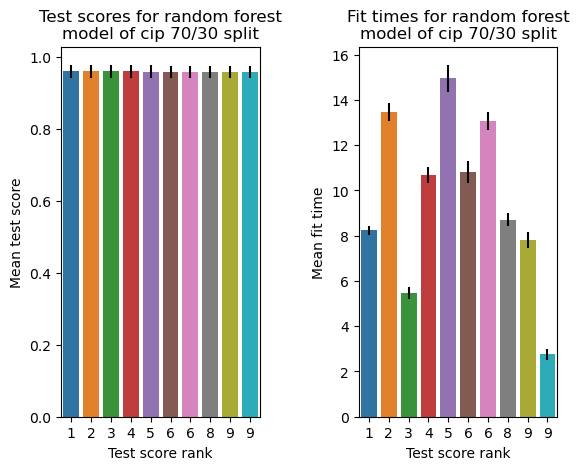

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
33,8.244265,0.193280,0.427431,0.063585,600,2,2,sqrt,25,entropy,...,0.960,0.935,0.965,0.924623,0.940,0.985,0.975,0.959285,0.018106,1
49,13.457153,0.399108,0.554115,0.076445,1000,2,2,sqrt,25,entropy,...,0.965,0.935,0.965,0.924623,0.940,0.985,0.975,0.958950,0.017859,2
32,5.466332,0.276233,0.347067,0.050806,400,2,2,sqrt,40,entropy,...,0.960,0.935,0.960,0.924623,0.940,0.985,0.975,0.958618,0.017692,3
23,10.666697,0.354421,0.466925,0.059176,800,2,2,sqrt,40,entropy,...,0.960,0.935,0.965,0.924623,0.940,0.985,0.975,0.958616,0.017790,4
4,14.961849,0.596375,0.598015,0.062032,1000,2,1,sqrt,35,entropy,...,0.965,0.935,0.960,0.924623,0.935,0.985,0.975,0.958283,0.017525,5
6,10.832834,0.484430,0.526273,0.088367,800,5,4,sqrt,25,entropy,...,0.960,0.935,0.955,0.919598,0.950,0.985,0.975,0.958283,0.016452,6
10,13.065011,0.391287,0.572076,0.060756,1000,2,4,sqrt,25,entropy,...,0.960,0.935,0.955,0.919598,0.950,0.985,0.975,0.958283,0.016452,6
40,8.709308,0.284785,0.423448,0.056397,600,2,1,sqrt,15,entropy,...,0.960,0.935,0.960,0.924623,0.940,0.985,0.975,0.958281,0.016947,8
35,7.808647,0.335505,0.390525,0.050257,600,10,1,sqrt,10,gini,...,0.955,0.930,0.955,0.924623,0.945,0.985,0.975,0.957950,0.016954,9
58,2.754587,0.229151,0.249937,0.052710,200,10,2,sqrt,25,entropy,...,0.955,0.935,0.955,0.924623,0.945,0.985,0.975,0.957950,0.016757,9


In [20]:
rf_result_cip70 = rf_random_cip.fit(cip_X_train70, cip_y_train70)
df_rf_result_cip70 = pd.DataFrame(rf_result_cip70.cv_results_).sort_values('rank_test_score')
print(f'Best score: {rf_result_cip70.best_score_}')
print(f'Best parameters: {rf_result_cip70.best_params_}')
plot_search_results(df_rf_result_cip70, 'random forest', 'cip', '70/30')
df_rf_result_cip70.head(10)

All of the models from this split have lower recall than the 80/20 split and most have substantially higher fit times than the best model from the other split.

### 4.5.3 cfx Random Forest

Best score: 0.7157236030319054
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}


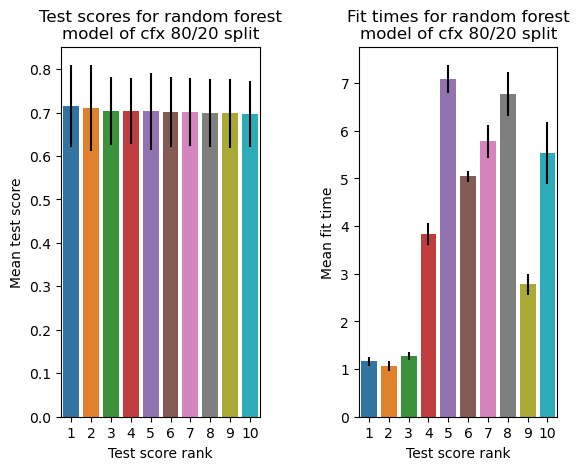

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
29,1.160181,0.086804,0.082627,0.004981,200,2,1,sqrt,10,entropy,...,0.688525,0.737705,0.901639,0.645161,0.622951,0.688525,0.754098,0.715724,0.094410,1
23,1.065965,0.106733,0.080326,0.002701,200,5,1,log2,20,entropy,...,0.754098,0.655738,0.885246,0.709677,0.672131,0.639344,0.688525,0.710118,0.098707,2
50,1.279666,0.087803,0.078919,0.000927,200,2,1,sqrt,40,gini,...,0.704918,0.672131,0.819672,0.629032,0.672131,0.655738,0.754098,0.703702,0.077390,3
57,3.826992,0.232209,0.219122,0.013711,600,5,1,sqrt,40,entropy,...,0.721311,0.672131,0.819672,0.661290,0.622951,0.655738,0.737705,0.703649,0.076170,4
2,7.083103,0.301829,0.372178,0.020648,1000,2,1,sqrt,40,entropy,...,0.672131,0.655738,0.852459,0.629032,0.622951,0.672131,0.754098,0.702574,0.087932,5
56,5.045511,0.118345,0.308973,0.037714,800,2,1,log2,100,gini,...,0.672131,0.655738,0.786885,0.629032,0.622951,0.672131,0.754098,0.701481,0.081257,6
6,5.778897,0.342203,0.294629,0.014641,800,2,1,sqrt,80,entropy,...,0.672131,0.672131,0.786885,0.629032,0.639344,0.672131,0.754098,0.701481,0.077843,7
51,6.765456,0.460196,0.356506,0.013457,1000,2,1,sqrt,80,entropy,...,0.672131,0.672131,0.770492,0.629032,0.622951,0.672131,0.754098,0.699295,0.077716,8
15,2.774645,0.216339,0.149480,0.005226,400,5,1,sqrt,40,gini,...,0.721311,0.655738,0.819672,0.629032,0.622951,0.655738,0.737705,0.698237,0.079477,9
0,5.532258,0.649825,0.336150,0.032484,800,5,1,log2,40,gini,...,0.704918,0.639344,0.803279,0.661290,0.622951,0.655738,0.737705,0.697091,0.075349,10


In [21]:
rf_result_cfx80 = rf_random.fit(cfx_X_train80, cfx_y_train80)
df_rf_result_cfx80 = pd.DataFrame(rf_result_cfx80.cv_results_).sort_values('rank_test_score')
print(f'Best score: {rf_result_cfx80.best_score_}')
print(f'Best parameters: {rf_result_cfx80.best_params_}')
plot_search_results(df_rf_result_cfx80, 'random forest', 'cfx', '80/20')
df_rf_result_cfx80.head(10)

The best recall was 0.713503 although there is significantly large variance between splits as the standard deviation was consistently twice than of those seen with azm.

Best score: 0.799743768926159
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}


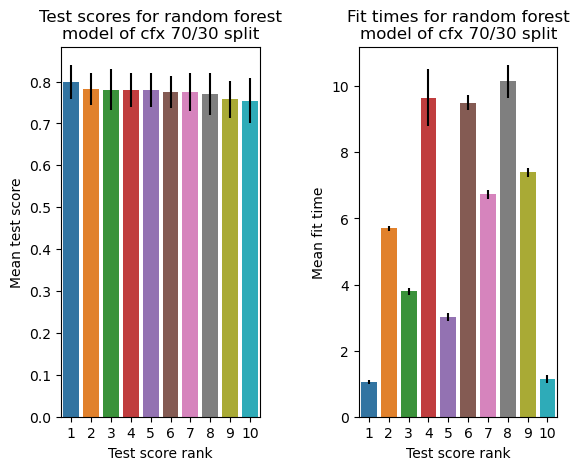

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
29,1.048761,0.073075,0.078316,0.005300,200,2,1,sqrt,10,entropy,...,0.792453,0.740741,0.740741,0.796296,0.792453,0.792453,0.833333,0.799744,0.040410,1
54,5.706310,0.079142,0.376346,0.014058,1200,5,2,sqrt,10,entropy,...,0.754717,0.851852,0.722222,0.759259,0.754717,0.754717,0.833333,0.782180,0.038979,2
3,3.796836,0.105654,0.261060,0.010008,800,10,4,sqrt,70,entropy,...,0.754717,0.833333,0.666667,0.814815,0.773585,0.735849,0.833333,0.780876,0.048653,3
41,9.653195,0.860797,0.683387,0.052196,2000,10,4,sqrt,30,entropy,...,0.754717,0.833333,0.685185,0.814815,0.773585,0.735849,0.833333,0.779688,0.039925,4
43,3.025124,0.119128,0.202277,0.011978,600,5,1,sqrt,10,gini,...,0.754717,0.722222,0.759259,0.777778,0.773585,0.773585,0.833333,0.779688,0.039969,5
20,9.506515,0.230894,0.624379,0.043957,2000,5,4,sqrt,100,entropy,...,0.754717,0.814815,0.703704,0.796296,0.773585,0.735849,0.833333,0.774680,0.038008,6
22,6.729117,0.142797,0.462340,0.035914,1400,2,2,sqrt,10,gini,...,0.735849,0.833333,0.722222,0.759259,0.773585,0.698113,0.833333,0.774633,0.046019,7
53,10.150134,0.500394,0.710209,0.063127,2000,2,2,sqrt,100,entropy,...,0.735849,0.870370,0.740741,0.740741,0.754717,0.698113,0.833333,0.769625,0.049629,8
8,7.391758,0.129761,0.517598,0.033362,1600,5,4,sqrt,90,gini,...,0.754717,0.814815,0.648148,0.796296,0.773585,0.735849,0.833333,0.757326,0.044648,9
23,1.147369,0.124709,0.079497,0.007627,200,5,1,log2,20,entropy,...,0.735849,0.814815,0.685185,0.759259,0.735849,0.679245,0.833333,0.754694,0.054333,10


In [22]:
rf_result_cfx70 = rf_random.fit(cfx_X_train70, cfx_y_train70)
df_rf_result_cfx70 = pd.DataFrame(rf_result_cfx70.cv_results_).sort_values('rank_test_score')
print(f'Best score: {rf_result_cfx70.best_score_}')
print(f'Best parameters: {rf_result_cfx70.best_params_}')
plot_search_results(df_rf_result_cfx70, 'random forest', 'cfx', '70/30')
df_rf_result_cfx70.head(10)

The results for this split are substantially more promising than the 80/20 split. The best recall is 0.810762 and the standard deviation is between 0.03-0.05 (comparable to azm). The fit time of the model with best recall was 2.837534 seconds, making it a promising model. Its parameters are as follows:

In [23]:
rf_cfx70_best_params = df_rf_result_cfx70['params'].iloc[0]
rf_cfx70_best_params

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'entropy'}

## 4.6 Xgboost

### 4.6.1 azm Xgboost

In [24]:
xgbc = xgb.XGBClassifier(random_state=75)
random_grid_xgb = {
 'learning_rate' : [0.05, 0.10 , 0.15, 0.20, 0.25, 0.30],
 'max_depth' : [3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [1, 3, 5, 7],
 'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
 'colsample_bytree' : [0.3, 0.4, 0.5 , 0.7]
}
xgb_random = RandomizedSearchCV(estimator=xgbc, param_distributions=random_grid_xgb,
                              n_iter=60, scoring='recall', n_jobs=-1, cv=cv, random_state=101)

Best score: 0.6935189721813925
Best parameters: {'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.5}


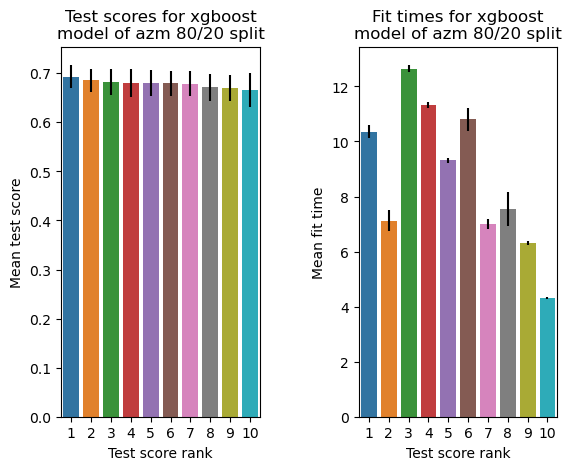

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
12,10.360670,0.239486,0.059811,0.005156,1,15,0.3,0.1,0.5,"{'min_child_weight': 1, 'max_depth': 15, 'lear...",...,0.679487,0.666667,0.717949,0.707006,0.692308,0.717949,0.673077,0.693519,0.024023,1
51,7.126438,0.368554,0.058530,0.004869,1,10,0.25,0.4,0.4,"{'min_child_weight': 1, 'max_depth': 10, 'lear...",...,0.660256,0.685897,0.679487,0.662420,0.698718,0.698718,0.673077,0.685854,0.023176,2
55,12.652082,0.137582,0.056968,0.003022,1,12,0.15,0.1,0.7,"{'min_child_weight': 1, 'max_depth': 12, 'lear...",...,0.660256,0.666667,0.679487,0.656051,0.692308,0.705128,0.673077,0.682016,0.026154,3
57,11.333207,0.118439,0.055968,0.004038,3,12,0.3,0.0,0.7,"{'min_child_weight': 3, 'max_depth': 12, 'lear...",...,0.679487,0.647436,0.673077,0.656051,0.679487,0.711538,0.705128,0.680742,0.028285,4
18,9.324841,0.093757,0.057199,0.003734,1,12,0.15,0.3,0.5,"{'min_child_weight': 1, 'max_depth': 12, 'lear...",...,0.653846,0.673077,0.685897,0.662420,0.679487,0.698718,0.679487,0.680723,0.025979,5
23,10.802072,0.404540,0.068403,0.040311,3,10,0.25,0.3,0.7,"{'min_child_weight': 3, 'max_depth': 10, 'lear...",...,0.673077,0.647436,0.647436,0.668790,0.679487,0.717949,0.679487,0.679457,0.025151,6
2,7.006146,0.179983,0.058359,0.004591,3,12,0.3,0.1,0.4,"{'min_child_weight': 3, 'max_depth': 12, 'lear...",...,0.679487,0.641026,0.685897,0.656051,0.660256,0.717949,0.673077,0.679035,0.025862,7
59,7.551621,0.629088,0.054760,0.007159,5,12,0.3,0.0,0.5,"{'min_child_weight': 5, 'max_depth': 12, 'lear...",...,0.660256,0.634615,0.673077,0.649682,0.660256,0.666667,0.673077,0.671346,0.026856,8
11,6.317898,0.077479,0.056163,0.003312,3,10,0.3,0.4,0.4,"{'min_child_weight': 3, 'max_depth': 10, 'lear...",...,0.653846,0.647436,0.647436,0.662420,0.673077,0.705128,0.679487,0.670058,0.025721,9
39,4.308473,0.031649,0.054560,0.001566,3,8,0.3,0.4,0.3,"{'min_child_weight': 3, 'max_depth': 8, 'learn...",...,0.641026,0.621795,0.615385,0.636943,0.647436,0.717949,0.698718,0.666648,0.034378,10


In [25]:
xgb_result_azm80 = xgb_random.fit(azm_X_train80, azm_y_train80)
df_xgb_result_azm80 = pd.DataFrame(xgb_result_azm80.cv_results_).sort_values('rank_test_score')
print(f'Best score: {xgb_result_azm80.best_score_}')
print(f'Best parameters: {xgb_result_azm80.best_params_}')
plot_search_results(df_xgb_result_azm80, 'xgboost', 'azm', '80/20')
df_xgb_result_azm80.head(10)

The top five results had recall above 0.68 with low standard deviation of roughly 0.025. The top ranked model has a recall of 0.693519 and a fit time of 10.568306, only one second longer than the best azm model.

In [26]:
gxb_azm80_best_params = df_xgb_result_azm80['params'].iloc[0]
gxb_azm80_best_params

{'min_child_weight': 1,
 'max_depth': 15,
 'learning_rate': 0.3,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

Best score: 0.680871618720481
Best parameters: {'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.5}


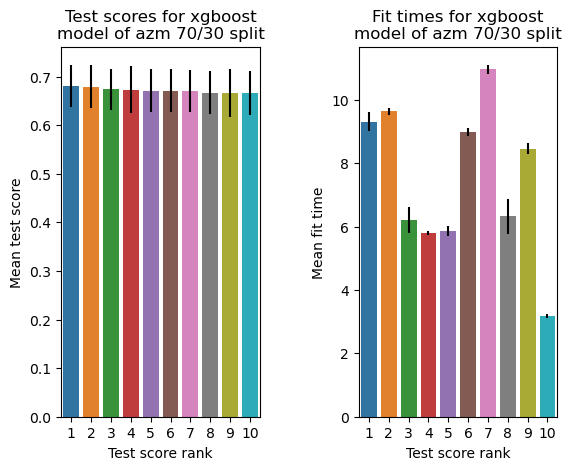

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
12,9.305509,0.304483,0.057104,0.005429,1,15,0.3,0.1,0.5,"{'min_child_weight': 1, 'max_depth': 15, 'lear...",...,0.661765,0.786765,0.693431,0.635036,0.686131,0.713235,0.661765,0.680872,0.043616,1
57,9.629410,0.123895,0.053787,0.003074,3,12,0.3,0.0,0.7,"{'min_child_weight': 3, 'max_depth': 12, 'lear...",...,0.661765,0.786765,0.700730,0.649635,0.635036,0.683824,0.669118,0.678900,0.044396,2
2,6.215633,0.407037,0.054369,0.002987,3,12,0.3,0.1,0.4,"{'min_child_weight': 3, 'max_depth': 12, 'lear...",...,0.683824,0.757353,0.715328,0.642336,0.664234,0.698529,0.683824,0.674041,0.042046,3
51,5.798193,0.071359,0.052514,0.005017,1,10,0.25,0.4,0.4,"{'min_child_weight': 1, 'max_depth': 10, 'lear...",...,0.639706,0.779412,0.722628,0.642336,0.656934,0.720588,0.654412,0.673079,0.048232,4
11,5.868060,0.161543,0.055742,0.004101,3,10,0.3,0.4,0.4,"{'min_child_weight': 3, 'max_depth': 10, 'lear...",...,0.639706,0.772059,0.729927,0.642336,0.642336,0.698529,0.676471,0.671103,0.044266,5
23,8.990232,0.120615,0.053615,0.004907,3,10,0.25,0.3,0.7,"{'min_child_weight': 3, 'max_depth': 10, 'lear...",...,0.669118,0.742647,0.744526,0.642336,0.635036,0.698529,0.683824,0.671086,0.044512,6
55,10.953806,0.149547,0.060889,0.011270,1,12,0.15,0.1,0.7,"{'min_child_weight': 1, 'max_depth': 12, 'lear...",...,0.647059,0.750000,0.708029,0.642336,0.642336,0.735294,0.654412,0.670137,0.043537,7
59,6.324706,0.547562,0.049779,0.005722,5,12,0.3,0.0,0.5,"{'min_child_weight': 5, 'max_depth': 12, 'lear...",...,0.654412,0.779412,0.708029,0.649635,0.635036,0.698529,0.683824,0.667211,0.044874,8
18,8.447784,0.175833,0.057471,0.011682,1,12,0.15,0.3,0.5,"{'min_child_weight': 1, 'max_depth': 12, 'lear...",...,0.647059,0.772059,0.729927,0.642336,0.642336,0.705882,0.654412,0.666234,0.049885,9
5,3.182017,0.056516,0.053963,0.007471,1,6,0.3,0.0,0.3,"{'min_child_weight': 1, 'max_depth': 6, 'learn...",...,0.661765,0.757353,0.751825,0.642336,0.635036,0.661765,0.654412,0.665729,0.045078,10


In [27]:
xgb_result_azm70 = xgb_random.fit(azm_X_train70, azm_y_train70)
df_xgb_result_azm70 = pd.DataFrame(xgb_result_azm70.cv_results_).sort_values('rank_test_score')
print(f'Best score: {xgb_result_azm70.best_score_}')
print(f'Best parameters: {xgb_result_azm70.best_params_}')
plot_search_results(df_xgb_result_azm70, 'xgboost', 'azm', '70/30')
df_xgb_result_azm70.head(10)

The best recall score is 0.680872 with a mean fit time of 9.859021, so the 80/20 test split is performing better.

### 4.6.2 cip Xgboost
Due to the large number of features in cip, xgboost may prove to be computationally expensive. As a test, I ran just three iterations of a random search to gauge fit times.

In [28]:
xgb_random_cip = RandomizedSearchCV(estimator=xgbc, param_distributions=random_grid_xgb,
                              n_iter=3, scoring='recall', n_jobs=-1, cv=cv, random_state=101)

In [29]:
xgb_result_cip80 = xgb_random_cip.fit(cip_X_train80, cip_y_train80)
pd.DataFrame(xgb_result_cip80.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
1,56.997994,0.580793,1.055863,0.037917,7,5,0.05,0.3,0.4,"{'min_child_weight': 7, 'max_depth': 5, 'learn...",...,0.978166,0.991266,0.978070,0.973684,0.986842,0.978166,0.965066,0.976944,0.009511,1
0,44.948909,2.060110,1.107849,0.078375,7,15,0.15,0.4,0.3,"{'min_child_weight': 7, 'max_depth': 15, 'lear...",...,0.982533,0.995633,0.973684,0.982456,0.986842,0.973799,0.973799,0.975774,0.012566,2
2,73.738140,6.527317,1.140900,0.197602,3,8,0.05,0.2,0.4,"{'min_child_weight': 3, 'max_depth': 8, 'learn...",...,0.982533,0.991266,0.973684,0.969298,0.982456,0.982533,0.969432,0.975771,0.009309,3


With mean fit times above 50 seconds, gains in the recall are not worth the computational time.

### 4.6.3 cfx Xgboost

Best score: 0.7004759386567954
Best parameters: {'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.5}


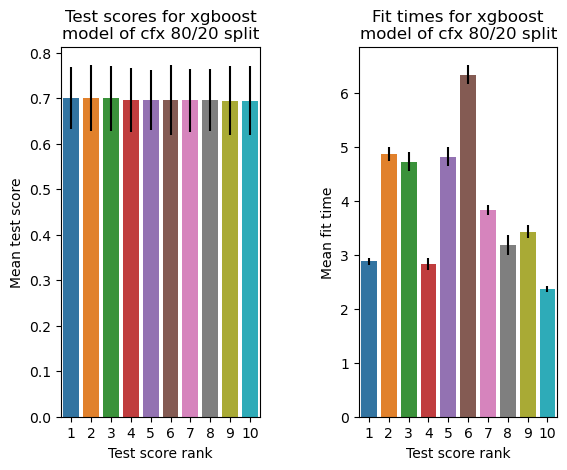

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
31,2.879103,0.069399,0.039880,0.001281,5,10,0.2,0.1,0.5,"{'min_child_weight': 5, 'max_depth': 10, 'lear...",...,0.655738,0.737705,0.819672,0.677419,0.606557,0.639344,0.754098,0.700476,0.068657,1
12,4.860158,0.130972,0.042258,0.004090,1,15,0.3,0.1,0.5,"{'min_child_weight': 1, 'max_depth': 15, 'lear...",...,0.655738,0.655738,0.803279,0.677419,0.622951,0.672131,0.737705,0.700405,0.072064,2
57,4.726256,0.182390,0.041890,0.002887,3,12,0.3,0.0,0.7,"{'min_child_weight': 3, 'max_depth': 12, 'lear...",...,0.672131,0.721311,0.803279,0.629032,0.622951,0.639344,0.737705,0.699401,0.070909,3
11,2.831397,0.108484,0.039981,0.001645,3,10,0.3,0.4,0.4,"{'min_child_weight': 3, 'max_depth': 10, 'lear...",...,0.672131,0.688525,0.836066,0.645161,0.622951,0.639344,0.737705,0.696157,0.069830,4
23,4.818939,0.182654,0.043424,0.005182,3,10,0.25,0.3,0.7,"{'min_child_weight': 3, 'max_depth': 10, 'lear...",...,0.655738,0.704918,0.803279,0.645161,0.606557,0.622951,0.737705,0.696087,0.065882,5
55,6.337884,0.182058,0.042330,0.003397,1,12,0.15,0.1,0.7,"{'min_child_weight': 1, 'max_depth': 12, 'lear...",...,0.622951,0.672131,0.819672,0.677419,0.622951,0.606557,0.737705,0.696034,0.077193,6
33,3.830905,0.092626,0.041127,0.001837,5,6,0.25,0.2,0.7,"{'min_child_weight': 5, 'max_depth': 6, 'learn...",...,0.655738,0.721311,0.819672,0.661290,0.606557,0.622951,0.754098,0.695064,0.068779,7
2,3.185887,0.189048,0.050616,0.009456,3,12,0.3,0.1,0.4,"{'min_child_weight': 3, 'max_depth': 12, 'lear...",...,0.672131,0.688525,0.819672,0.645161,0.606557,0.639344,0.721311,0.695029,0.067892,8
26,3.428425,0.117906,0.042977,0.008127,3,15,0.1,0.2,0.5,"{'min_child_weight': 3, 'max_depth': 15, 'lear...",...,0.655738,0.704918,0.836066,0.629032,0.606557,0.590164,0.754098,0.693971,0.075415,9
30,2.363786,0.059612,0.041039,0.002654,5,10,0.2,0.1,0.4,"{'min_child_weight': 5, 'max_depth': 10, 'lear...",...,0.639344,0.737705,0.836066,0.677419,0.606557,0.590164,0.754098,0.693954,0.075560,10


In [30]:
xgb_result_cfx80 = xgb_random.fit(cfx_X_train80, cfx_y_train80)
df_xgb_result_cfx80 = pd.DataFrame(xgb_result_cfx80.cv_results_).sort_values('rank_test_score')
print(f'Best score: {xgb_result_cfx80.best_score_}')
print(f'Best parameters: {xgb_result_cfx80.best_params_}')
plot_search_results(df_xgb_result_cfx80, 'xgboost', 'cfx', '80/20')
df_xgb_result_cfx80.head(10)

The best recall was 0.700476 with a mean fit time of 4.564991 seconds, which is substantially below the recall of the best random forest model.

Best score: 0.7399487537852317
Best parameters: {'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.7}


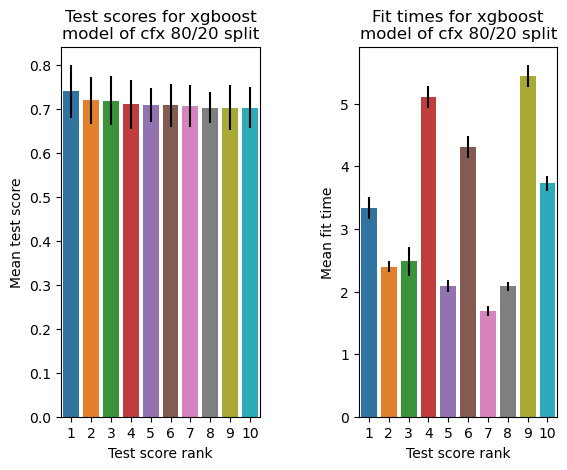

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
42,3.335238,0.170645,0.039242,0.002294,1,5,0.05,0.4,0.7,"{'min_child_weight': 1, 'max_depth': 5, 'learn...",...,0.716981,0.685185,0.629630,0.740741,0.773585,0.679245,0.796296,0.739949,0.060401,1
8,2.396317,0.092160,0.039147,0.002137,1,4,0.1,0.0,0.5,"{'min_child_weight': 1, 'max_depth': 4, 'learn...",...,0.679245,0.648148,0.629630,0.703704,0.792453,0.754717,0.759259,0.719054,0.052870,2
35,2.479838,0.238465,0.040208,0.003287,1,5,0.1,0.1,0.4,"{'min_child_weight': 1, 'max_depth': 5, 'learn...",...,0.735849,0.648148,0.648148,0.703704,0.754717,0.660377,0.759259,0.718891,0.056541,3
17,5.112117,0.179004,0.040132,0.001812,1,12,0.05,0.0,0.7,"{'min_child_weight': 1, 'max_depth': 12, 'lear...",...,0.660377,0.814815,0.685185,0.703704,0.735849,0.679245,0.759259,0.710109,0.055819,4
27,2.089729,0.094942,0.039913,0.003152,1,6,0.15,0.4,0.3,"{'min_child_weight': 1, 'max_depth': 6, 'learn...",...,0.698113,0.759259,0.703704,0.685185,0.735849,0.679245,0.759259,0.708945,0.037694,5
12,4.310993,0.177864,0.039968,0.001504,1,15,0.3,0.1,0.5,"{'min_child_weight': 1, 'max_depth': 15, 'lear...",...,0.660377,0.814815,0.703704,0.648148,0.754717,0.698113,0.796296,0.707734,0.049010,6
24,1.685918,0.083157,0.040606,0.004163,3,5,0.05,0.0,0.3,"{'min_child_weight': 3, 'max_depth': 5, 'learn...",...,0.660377,0.666667,0.703704,0.722222,0.698113,0.622642,0.796296,0.707501,0.047718,7
5,2.084315,0.072097,0.040710,0.006965,1,6,0.3,0.0,0.3,"{'min_child_weight': 1, 'max_depth': 6, 'learn...",...,0.698113,0.796296,0.703704,0.685185,0.716981,0.698113,0.722222,0.702772,0.035734,8
55,5.446578,0.176842,0.042084,0.004439,1,12,0.15,0.1,0.7,"{'min_child_weight': 1, 'max_depth': 12, 'lear...",...,0.660377,0.814815,0.685185,0.629630,0.716981,0.679245,0.777778,0.702725,0.050446,9
37,3.731518,0.121099,0.040413,0.002949,1,10,0.1,0.4,0.5,"{'min_child_weight': 1, 'max_depth': 10, 'lear...",...,0.641509,0.814815,0.703704,0.685185,0.716981,0.679245,0.740741,0.702632,0.046846,10


In [31]:
xgb_result_cfx70 = xgb_random.fit(cfx_X_train70, cfx_y_train70)
df_xgb_result_cfx70 = pd.DataFrame(xgb_result_cfx70.cv_results_).sort_values('rank_test_score')
print(f'Best score: {xgb_result_cfx70.best_score_}')
print(f'Best parameters: {xgb_result_cfx70.best_params_}')
plot_search_results(df_xgb_result_cfx70, 'xgboost', 'cfx', '80/20')
df_xgb_result_cfx70.head(10)

The best mean test score for the 70/30 split was 0.739949 with a fit time of 4.777952.

## 4.7 Model Selection

Now I have the top performing random forest and Xgboost models for each dataset, and then compared them using their confusion matrices, fit time, recall, and ROC AUC scores.

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def display_confusion_matrix(y_test, y_predict, model):
    """This function takes the actual and predicted y values and a model to create a confusion matrix,
    and plot said matrix with the labels of 'resistant' and 'sensitive' for 1 and 0."""
    
    cm = confusion_matrix(y_test, y_predict, labels = model.classes_)
    fig, ax = plt.subplots()
    display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                        display_labels = ['sensitive', 'resistant'])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels = ['sensitive', 'resistant'], fontsize = 8)
    ax.set_yticklabels(labels = ['sensitive', 'resistant'], fontsize = 8)
    display_cm.plot(ax = ax)
    plt.show()

In [33]:
def plot_model_comparison(antibiotic, comparison_df):
    """The input of this function is an antibiotic name and a dataframe with data of a 'model',
    'fit_time', 'recall_score', and  'roc_auc_score'. It creates three bar plots for the fit time, recall,
    and ROC AUC, separating by model."""
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))

    g = sns.barplot(ax=ax1, data=comparison_df, x='model', y='fit_time')
    g.bar_label(container=g.containers[0])
    g.set_xlabel('Model')
    g.set_ylabel('Fit time (s)')
    g.set_title('Fit time')

    h = sns.barplot(ax=ax2, data=comparison_df, x='model', y='recall_score')
    h.set_ylim(0,1)
    h.bar_label(container=h.containers[0])
    h.set_xlabel('Model')
    h.set_ylabel('Recall score')
    h.set_title('Recall scores')

    i = sns.barplot(ax=ax3, data=comparison_df, x='model', y='roc_auc_score')
    i.set_ylim(0,1)
    i.bar_label(container=i.containers[0])
    i.set_xlabel('Model')
    i.set_ylabel('ROC AUC score')
    i.set_title('ROC AUC scores')

    fig.suptitle(f'Model analysis for {antibiotic}', fontsize=16)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [34]:
def plot_feature_importances(antibiotic, model_name, model):
    """When an antibiotic name, model name, and a model are input, this function creates a dataframe
    of the model's features and ranked feature importance, creates a pairplot showing the top 20 important
    features, and prints the top 10 important features."""
    
    df = pd.DataFrame({'feature': model.feature_names_in_,
                      'feature_importance': model.feature_importances_})
    df.sort_values('feature_importance', ascending=False, inplace=True)
    df = df.iloc[:20, :]

    sns.pointplot(data=df, y='feature', x='feature_importance')
    plt.title(f'Features of importance in {model_name} model for {antibiotic}')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature');

    for i in range(10):
        feature = df.iloc[i,0]
        importance = df.iloc[i,1]
        print(f'Feature {i+1}: {feature}')
        print(f'    Importance: {importance}')

### 4.7.1 azm Model Selection

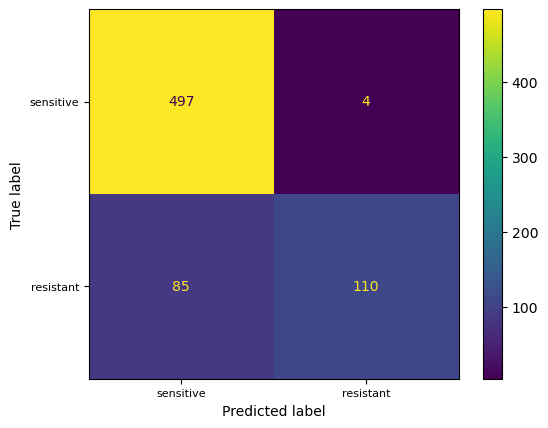

In [35]:
azm_rf_best = RandomForestClassifier(n_estimators=800,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    max_features='sqrt',
                                    max_depth=10,
                                    criterion='entropy')
start = time()
azm_rf_best.fit(azm_X_train80, azm_y_train80)
azm_rf_fit_time = time() - start
azm_rf_y_pred80 = azm_rf_best.predict(azm_X_test80)
azm_rf_recall = recall_score(azm_y_test80, azm_rf_y_pred80)
azm_rf_roc_auc = roc_auc_score(azm_y_test80, azm_rf_y_pred80)

display_confusion_matrix(azm_y_test80, azm_rf_y_pred80, azm_rf_best)

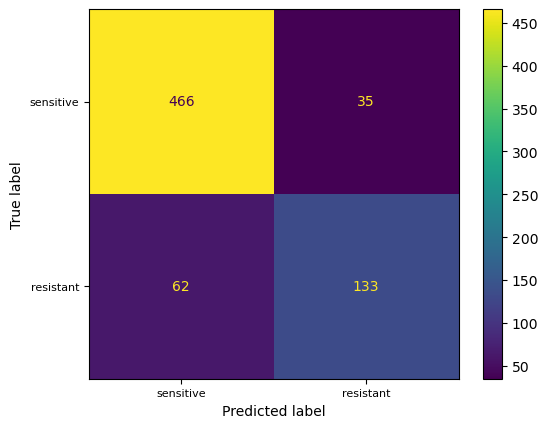

In [36]:
azm_xgb_best = xgb.XGBClassifier(min_child_weight=1,
                                 max_depth=15,
                                 learning_rate=0.3,
                                 gamma=0.1,
                                 colsample_bytree=0.5)
start = time()
azm_xgb_best.fit(azm_X_train80, azm_y_train80)
azm_xgb_fit_time = time() - start
azm_xgb_y_pred80 = azm_xgb_best.predict(azm_X_test80)
azm_xgb_recall = recall_score(azm_y_test80, azm_xgb_y_pred80)
azm_xgb_roc_auc = roc_auc_score(azm_y_test80, azm_xgb_y_pred80)

display_confusion_matrix(azm_y_test80, azm_xgb_y_pred80, azm_xgb_best)

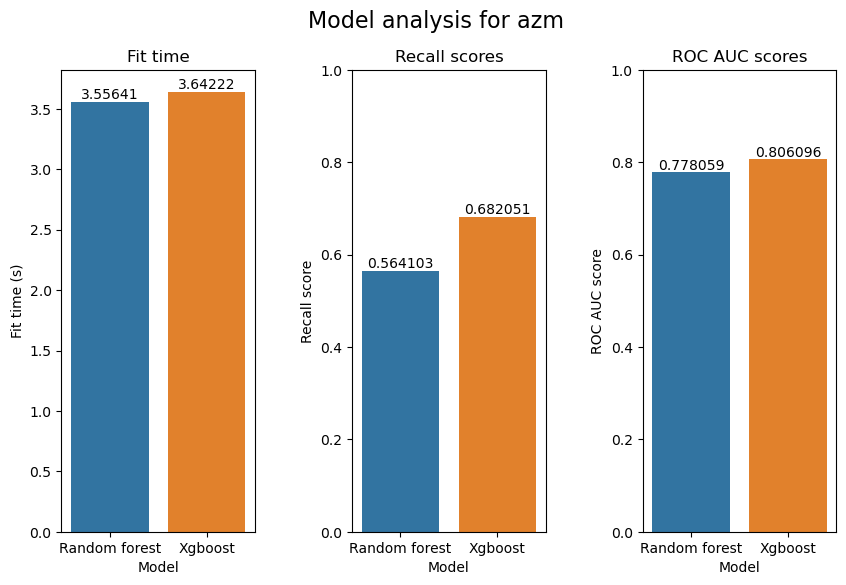

In [37]:
azm_models = pd.DataFrame({'model': ['Random forest', 'Xgboost'],
                           'fit_time': [azm_rf_fit_time, azm_xgb_fit_time],
                           'recall_score': [azm_rf_recall, azm_xgb_recall],
                           'roc_auc_score': [azm_rf_roc_auc, azm_xgb_roc_auc]
                          })
plot_model_comparison('azm', azm_models)

The Xgboost model substantially outperforms the random forest model in both recall and ROC AUC. The confusion matrices also indicate that the Xgboost correctly classifies more true positives.

Feature 1: GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG
    Importance: 0.2746787965297699
Feature 2: TCATCTCGTATGCCGTCTTCTGCTTGAAAAA
    Importance: 0.07508007436990738
Feature 3: ATATATAAGGGGTTGCCGTTCCGCAGTTGGG
    Importance: 0.04664245620369911
Feature 4: GCCTGCGGTACGGCGGGAAACAATGCCGCCC
    Importance: 0.04421335086226463
Feature 5: CAAACAAACTGGGGATATTATATGCATATCCT
    Importance: 0.027934785932302475
Feature 6: CATCTGCCTGGCAAACGCTTCCCCGTCGCCCTCGAA
    Importance: 0.0267002135515213
Feature 7: AACATCAGGAAAACGGCACATTCCACGCCGT
    Importance: 0.026340972632169724
Feature 8: AGGGTTGGTTGACGCTGCCGAAACCGAAGCACAAAACGAAAAATTCTACCGCGACTACCAA
    Importance: 0.020362108945846558
Feature 9: CGGCAATGCGGATATTACGGTCAAACCTGCCGA
    Importance: 0.017503146082162857
Feature 10: GCCGTCTTATTATAGGGAAGGCGTTCCCCGGAGCAC
    Importance: 0.010107947513461113


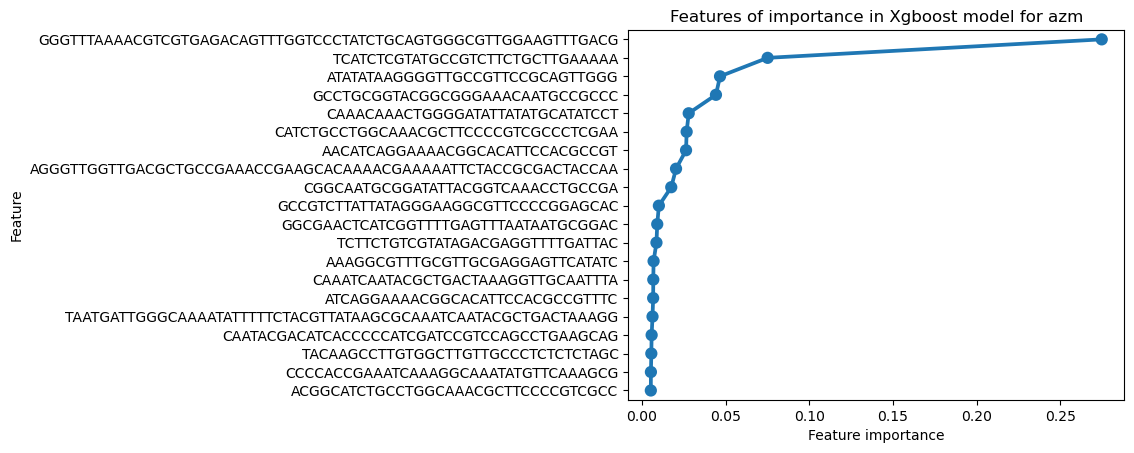

In [38]:
plot_feature_importances('azm', 'Xgboost', azm_xgb_best)

The most powerfully predicting feature is GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG, which has a feature importance of 0.27 while the next most important feature has an importance of 0.075. This unitig was indicated as the highest chi squared value during exploratory data analysis, confirming that it is an important predictor.

### 4.7.2 cip Model Selection

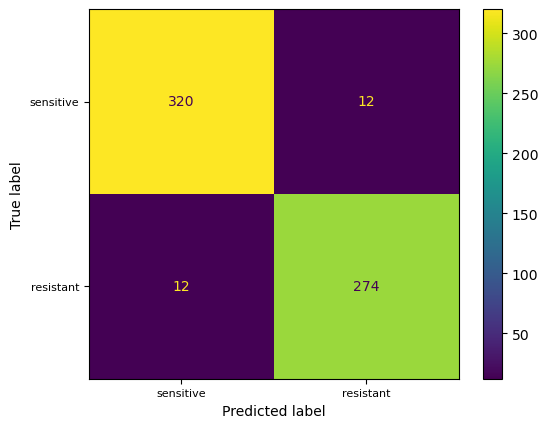

In [39]:
cip_rf_best = RandomForestClassifier(n_estimators=200,
                                    min_samples_split=10,
                                    min_samples_leaf=1,
                                    max_features='sqrt',
                                    max_depth=10,
                                    criterion='entropy')
start = time()
cip_rf_best.fit(cip_X_train80, cip_y_train80)
cip_rf_fit_time = time() - start
cip_rf_y_pred80 = cip_rf_best.predict(cip_X_test80)
cip_rf_recall = recall_score(cip_y_test80, cip_rf_y_pred80)
cip_rf_roc_auc = roc_auc_score(cip_y_test80, cip_rf_y_pred80)

display_confusion_matrix(cip_y_test80, cip_rf_y_pred80, cip_rf_best)

This model is highly accurate and only yields 11 false positives.

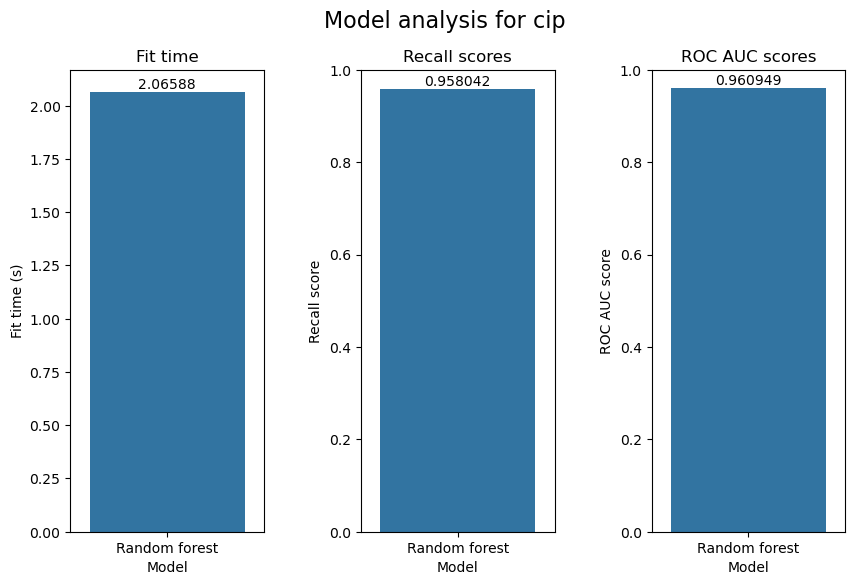

In [40]:
cip_models = pd.DataFrame({'model': ['Random forest'],
                           'fit_time': [cip_rf_fit_time],
                           'recall_score': [cip_rf_recall],
                           'roc_auc_score': [cip_rf_roc_auc]
                          })
plot_model_comparison('cip', cip_models)

The recall and ROC AUC scores are both above 0.96, which is phenomenal, and this model also has a low fit time of under 3 seconds.

Feature 1: GCGCAGCCGCAAATCTTGTTTTCCCATTCCGCC
    Importance: 0.02355501008839103
Feature 2: AAATTGCGGATCGATGCGCGAAGGGTCGAATGC
    Importance: 0.0182348124431008
Feature 3: GTGCGACAGCAAAGTCCAAACCAGCGTCCCCGCC
    Importance: 0.01804590967543329
Feature 4: CTTGGCACACAGTACCGAACCGGCGGCAATACCGATG
    Importance: 0.01272111877519041
Feature 5: CATTGTTTGGTCAATATTAATATCTTTATAAGG
    Importance: 0.012054154293540415
Feature 6: CGCACATTTTGGCTTTATCTTTTGGGCGCGCTGACTGCCCGTTTCGGCATCGGCGTG
    Importance: 0.011515353682095253
Feature 7: CCGAAGTAGATGCTGAAACCGTTGAAAAAGAACGCCA
    Importance: 0.010316924206893325
Feature 8: CAGGCGGAAATATAGTGGATTAAATTTAAAC
    Importance: 0.009588580118482695
Feature 9: CAGCTTGTGCAAAAGCTGCAAATACATCGGC
    Importance: 0.009364558249518831
Feature 10: GACTACATCAGCGGCAACATCTTGTTTATGCTGACCG
    Importance: 0.009240252786796101


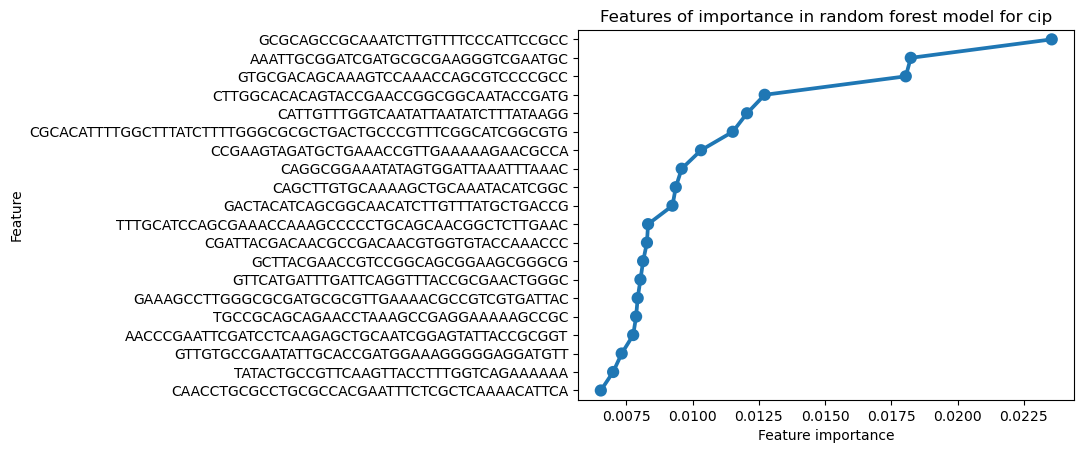

In [41]:
plot_feature_importances('cip', 'random forest', cip_rf_best)

The 6 most important features to this model were all identified in EDA. The most important feature was GTGCGACAGCAAAGTCCAAACCAGCGTCCCCGCC.

### 4.7.3 cfx Model Selection

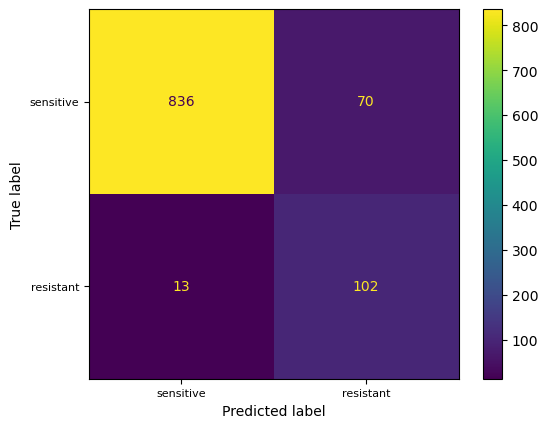

In [42]:
cfx_rf_best = RandomForestClassifier(n_estimators=600,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    max_features='sqrt',
                                    max_depth=10,
                                    criterion='entropy')
start = time()
cfx_rf_best.fit(cfx_X_train70, cfx_y_train70)
cfx_rf_fit_time = time() - start
cfx_rf_y_pred70 = cfx_rf_best.predict(cfx_X_test70)
cfx_rf_recall = recall_score(cfx_y_test70, cfx_rf_y_pred70)
cfx_rf_roc_auc = roc_auc_score(cfx_y_test70, cfx_rf_y_pred70)

display_confusion_matrix(cfx_y_test70, cfx_rf_y_pred70, cfx_rf_best)

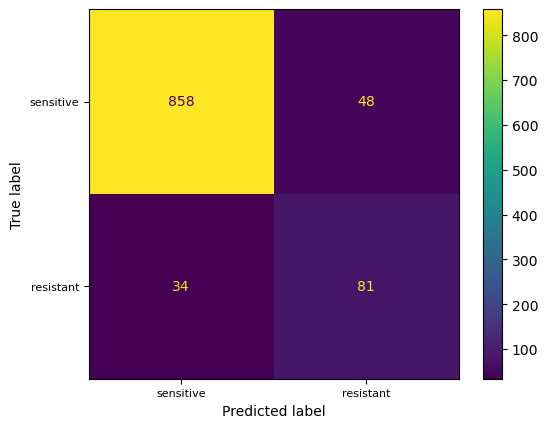

In [43]:
cfx_xgb_best = xgb.XGBClassifier(min_child_weight=1,
                                 max_depth=5,
                                 learning_rate=0.05,
                                 gamma=0.4,
                                 colsample_bytree=0.7)
start = time()
cfx_xgb_best.fit(cfx_X_train70, cfx_y_train70)
cfx_xgb_fit_time = time() - start
cfx_xgb_y_pred70 = cfx_xgb_best.predict(cfx_X_test70)
cfx_xgb_recall = recall_score(cfx_y_test70, cfx_xgb_y_pred70)
cfx_xgb_roc_auc = roc_auc_score(cfx_y_test70, cfx_xgb_y_pred70)

display_confusion_matrix(cfx_y_test70, cfx_xgb_y_pred70, cfx_xgb_best)

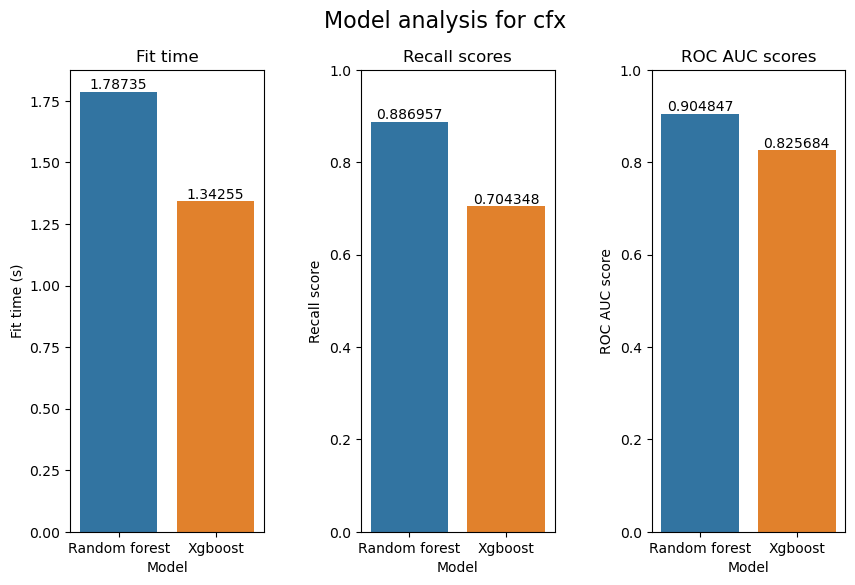

In [44]:
cfx_models = pd.DataFrame({'model': ['Random forest', 'Xgboost'],
                           'fit_time': [cfx_rf_fit_time, cfx_xgb_fit_time],
                           'recall_score': [cfx_rf_recall, cfx_xgb_recall],
                           'roc_auc_score': [cfx_rf_roc_auc, cfx_xgb_roc_auc]
                          })
plot_model_comparison('cfx', cfx_models)

The random forest model have higher recall and ROC AUC scores than the Xgboost model, and classified only 12 false positives.

Feature 1: AAACGACTTGCCTTTCTGTTCGAGTTTGTTCCTCAAAACATC
    Importance: 0.10038347666425344
Feature 2: AATATCGGTAAATCCGATGACGTGTGCAAAAAGGCTGCCCATCGGGTAATGGCGTTTTAATTCTT
    Importance: 0.1000558900190218
Feature 3: GTAATGGCGTTTTAATTCTTTTTCAAATACAAAGTT
    Importance: 0.09769885781426622
Feature 4: TTCGGCAACCTTGGGATCGAGCTGCCGCTTAATCCAGATAAACGACTTGCCTTTCTGTTCGAG
    Importance: 0.08511205115273593
Feature 5: GGATTCCGGCAAAGTGGATGCAACCGATACATTCAATACCCTGCCTTACAAAATCGGT
    Importance: 0.051694047840373174
Feature 6: CAAACAACTTCTATTACGCCAAAAGTCAGGCGATGCTCTACACC
    Importance: 0.05049933113603682
Feature 7: CAAGATACCCACGTTTATCCTACTTTGGATGTGCGC
    Importance: 0.025253720067385098
Feature 8: AAAACGCCGTCGTGCGTCAGTGCGGTATAGGC
    Importance: 0.02174838744094243
Feature 9: TAAAGGACAAAGACAGGAGGCGCGAATATACTTA
    Importance: 0.020609965744365
Feature 10: GGAGGCGCGAATATACTTATTATACGCACAGAAC
    Importance: 0.019452942255566794


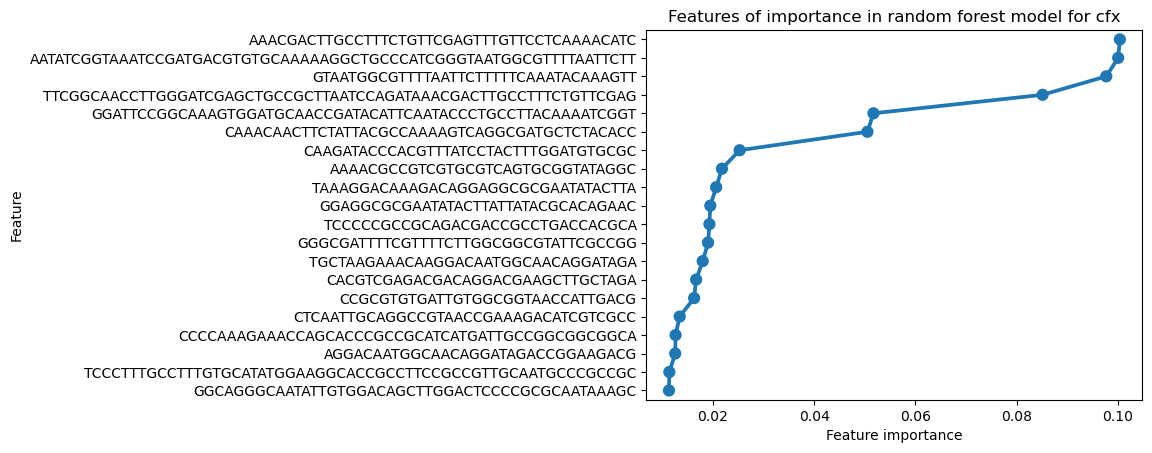

In [45]:
plot_feature_importances('cfx', 'random forest', cfx_rf_best)

9 of the 10 features with the highest importance were identified in EDA. Unlike the other two antibiotics, one unitig is not a vastly ahead of the rest in terms of importance.

## 4.8 Data Quality Assessment

In [46]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(antibiotic, model, X_train, y_train):
    """Plots a learning curve for a model using fractions of the training data."""
    
    fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
    train_size, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=fractions,
                                                           cv=5, scoring='recall', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.subplots(figsize=(10, 5))
    plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
    plt.xlabel('Training set size')
    plt.ylabel('CV scores')
    plt.title(f'{antibiotic} cross-validation score as training set size increases')
    plt.show()

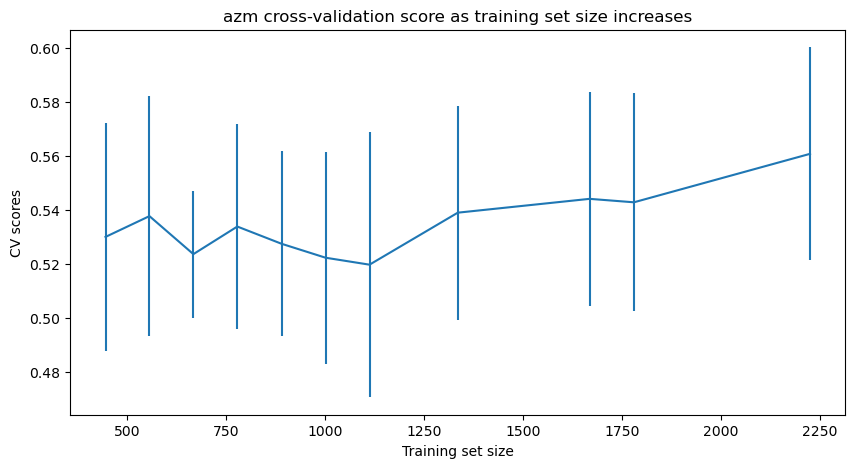

In [47]:
plot_learning_curve('azm', azm_rf_best, azm_X_train80, azm_y_train80)

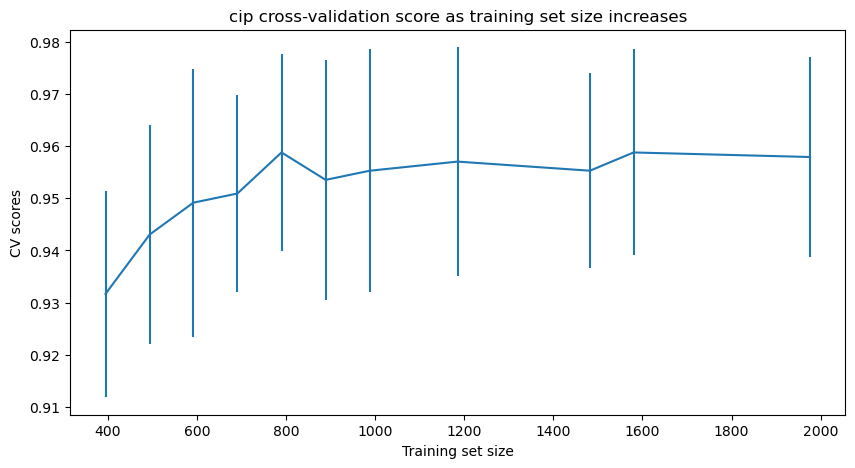

In [48]:
plot_learning_curve('cip', cip_rf_best, cip_X_train80, cip_y_train80)

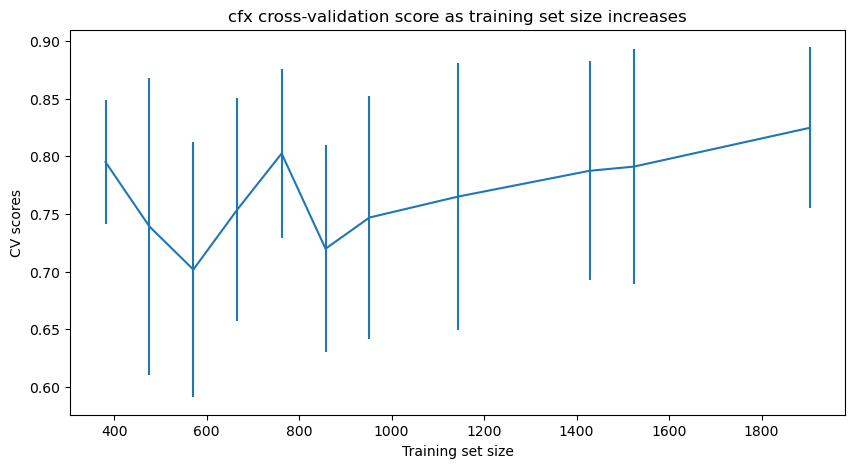

In [49]:
plot_learning_curve('cfx', cfx_rf_best, cfx_X_train70, cfx_y_train70)

Overall, for the three antibiotics, increasing the size of the training set does not substantially increase the cross validation scores, providing evidence that enough data is present in these sets.

## 4.9 Conclusion

Overall, after tuning both random forest and Xgboost models for two separate train/test splits of 80/20 and 70/30, I have generated three functional models to predict antibiotic resistance, each with a recall score above 0.68 and an ROC AUC score above 0.80. The azm model is the least accurate, which was expected in EDA as it had the fewest unitigs strongly correlated to resistance. The cip model was highly effective, with recall and ROC AUC above 0.96, most likely due to cip resistance being more present in gonorrhea populations. For all models, the features of importance aligned with the unitigs identified as strongly correlated with resistance previously in EDA.

## 4.10 Future directions

Due to the number of features, these models could benefit from further feature selection, as evidenced by many features having low importance in the final models. This would also reduce the size of the datasets and improve efficiency. Additionally, gathering of more data could improve accuracy, especially as the bacteria mutate often and these features of importance may change as population gene pools change as well as new genes for resistance continue to appear. Furthermore, other models such as AdaBoost may yield better results.

## 4.11 Saving models

In [50]:
from sklearn import __version__ as sklearn_version
import datetime
import pickle

In [51]:
azm_best_model = azm_xgb_best
azm_best_model.version = '1.0'
azm_best_model.pandas_version = pd.__version__
azm_best_model.numpy_version = np.__version__
azm_best_model.sklearn_version = sklearn_version
azm_best_model.X_columns = [col for col in azm_X_train80.columns]
azm_best_model.build_datetime = datetime.datetime.now()

with open('../models/azm_resistance_prediction_model.pkl', 'wb') as f:
    pickle.dump(azm_best_model, f)

In [52]:
cip_best_model = cip_rf_best
cip_best_model.version = '1.0'
cip_best_model.pandas_version = pd.__version__
cip_best_model.numpy_version = np.__version__
cip_best_model.sklearn_version = sklearn_version
cip_best_model.X_columns = [col for col in cip_X_train80.columns]
cip_best_model.build_datetime = datetime.datetime.now()

with open('../models/cip_resistance_prediction_model.pkl', 'wb') as f:
    pickle.dump(cip_best_model, f)

In [53]:
cfx_best_model = cfx_rf_best
cfx_best_model.version = '1.0'
cfx_best_model.pandas_version = pd.__version__
cfx_best_model.numpy_version = np.__version__
cfx_best_model.sklearn_version = sklearn_version
cfx_best_model.X_columns = [col for col in cfx_X_train70.columns]
cfx_best_model.build_datetime = datetime.datetime.now()

with open('../models/cfx_resistance_prediction_model.pkl', 'wb') as f:
    pickle.dump(cfx_best_model, f)